<a href="https://colab.research.google.com/github/JPA-BERT/jpa-bert.github.io/blob/master/notebooks/01PyTorchTEXT_transformer_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
    
このファイルは PyTorch のチュートリアルにあるファイル <https://pytorch.org/tutorials/beginner/transformer_tutorial.html> を翻訳して，加筆修正したもの
です。

すぐれたチュートリアルの内容，コードを公開された PyTorch 開発陣と Transfomer の原著論文著者陣 (Vaswani ら) に敬意を表します。

- Original: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
- Date: 2020-0807
- Translated and modified: Shin Asakawa <asakawa@ieee.org>

---

In [1]:
# 2020年8月11日現在，torchtext を upgrade しないとこのチュートリアルは動作しない
!pip install --upgrade torchtext

     |████████████████████████████████| 4.5MB 4.8MB/s 
     |████████████████████████████████| 1.1MB 59.0MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# from https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
%matplotlib inline

## ``nn.Transformer`` と ``TorchText`` を用いた Seq2Seq (系列-to-系列) モデル
<!--
## Sequence-to-Sequence Modeling with ``nn.Transformer`` and TorchText
-->

このチュートリアルでは，[nn.Transformer](https://pytorch.org/docs/master/nn.html?highlight=nn%20transformer#torch.nn.Transformer) モジュールを用いた sequence-to-sequnce (訳注:日本語では `seq2seq モデル` などと呼ばれます) モデルの訓練方法を示します。

<!--This is a tutorial on how to train a sequence-to-sequence model that uses the [nn.Transformer](https://pytorch.org/docs/master/nn.html?highlight=nn%20transformer#torch.nn.Transformer) module.-->

PyTorch リリース 1.2 には，[Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf) (訳注:初めてトランスフォーマーを提案した論文) に基づいた標準的なトランスフォーマーモジュールが含まれます。
トランスフォーマーは並列化が容易で，seq2seq モデルを凌ぐ性能が示されています。
``nn.Transfomer`` モジュールは，注意機構に基づいて，入出力情報間大域的依存性を解消する機構です
(最近の別実装は [nn.MultiheadAttention](https://pytorch.org/docs/master/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention))。
``nn.Transformer`` は単一要素で構成されており，本チュートリアル内の [nn.TransformerEncoder](https://pytorch.org/docs/master/nn.html?highlight=nn%20transformerencoder#torch.nn.TransformerEncoder) のごとく，修正，構成が容易です。
<!--
PyTorch 1.2 release includes a standard transformer module based on the paper [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf). 
The transformer model has been proved to be superior in quality for many sequence-to-sequence problems while being more parallelizable. 
The ``nn.Transformer`` module relies entirely on an attention mechanism (another module recently implemented as [nn.MultiheadAttention](https://pytorch.org/docs/master/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention) to draw global dependencies between input and output. 
The ``nn.Transformer`` module is now highly modularized such that a single component (like [nn.TransformerEncoder](https://pytorch.org/docs/master/nn.html?highlight=nn%20transformerencoder#torch.nn.TransformerEncoder) in this tutorial) can be easily adapted/composed.
-->

<div align="center">
<!--![](https://github.com/pytorch/tutorials/blob/gh-pages/_downloads/_static/img/transformer_architecture.jpg?raw=1)-->

<img src="https://pytorch.org/tutorials/_images/transformer_architecture.jpg" style="width:33%">
</div?




<!--# Define the model-->

# モデルの定義


<!--
In this tutorial, we train ``nn.TransformerEncoder`` model on a language modeling task. 
The language modeling task is to assign a probability for the likelihood of a given word (or a sequence of words) to follow a sequence of words. 
A sequence of tokens are passed to the embedding layer first, followed by a positional encoding layer to account for the order of the word (see the next paragraph for more details). 
The  ``nn.TransformerEncoder`` consists of multiple layers of [nn.TransformerEncoderLayer](https://pytorch.org/docs/master/nn.html?highlight=transformerencoderlayer#torch.nn.TransformerEncoderLayer).
Along with the input sequence, a square attention mask is required because the self-attention layers in ``nn.TransformerEncoder`` are only allowed to attend the earlier positions in the sequence. 
For the language modeling task, any tokens on the future positions should be masked. To have the actual words, the output of ``nn.TransformerEncoder`` model is sent to the final Linear layer, which is followed by a log-Softmax function.
-->

本チュートリアルでは 言語モデル課題で ``nn.TransformerEncoder`` モデルを学習します。
言語モデル課題とは 任意の単語 (または単語系列） が与えられた場合に，後続する単語の尤度（確率）を割り当てること指します。
文章を表す一連のトークン系列は，埋め込み層に入力され その後，単語の順番を符号化した位置符号化層の情報が付加されます(詳細は次パラグラフ参照)。
``nn.TransformerEncoder`` は [nn.TransformerEncoderLayer](https://pytorch.org/docs/master/nn.html?highlight=transformerencoderlayer#torch.nn.TransformerEncoderLayer) を構成要素とする複数層からなるニューラルネットワークです。
``nn.TransformerEncoder`` の自己注意層は 入力系列の初頭に近い位置にしか注意を払うことができないため、入力系列に対する マスク化注意機構が必要となります。
言語モデル課題では 将来の位置トークンがマスクされるます。
実際の単語を得るため  ``nn.TransformerEncoder`` モデルの出力は最終線形層に送られ 最終層として 対数ソフトマックス関数が設けられています。





In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

<!--
``PositionalEncoding`` module injects some information about the relative or absolute position of the tokens in the sequence. 
The positional encodings have the same dimension as the embeddings so that the two can be summed. 
Here, we use ``sine`` and ``cosine`` functions of different frequencies.
-->

位置符号化器 ``PositionalEncoding`` モジュールを用いることで，系列中のトークンの相対位置や絶対位置に関する情報を付加されます。
位置符号化器は埋め込みと同一次元を持ち 両者 を合算してトランスフォーマーへの入力とします。
ここでは 異なる周波数の ``sine``（正弦波） と ``cosine`` （余弦波） 関数を利用します。

### (訳注) Transformer: Attention is all you need
原著論文中の 位置符号化器は以下のように定義されている:
まず，マルチヘッド自己注意 (MHSA) は，クエリ，キー，バリューベクトルを学習すべきベクトルとして次式で定義される:

$$
\text{MultiHead}\left(Q,K,V\right)=\text{Concat}\left(\mathop{head}_1,\ldots,\mathop{head}_h\right)W^O
$$

ここで，各ヘッドは, $\text{head}_i =\text{Attention}\left(QW_i^Q,KW_i^K,VW_i^V\right)$ である。

それぞれの次元は以下のとおりである:
<!--The projections are parameter matrices-->

- $W_i^Q\in\mathbb{R}^{d_{\mathop{model}}\times d_k}$,
- $W_i^K \in\mathbb{R}^{d_{\mathop{model}}\times d_k}$,
- $W_i^V\in\mathbb{R}^{d_{\mathop{model}}\times d_v}$, 
- $W^O\in\mathbb{R}^{hd_v\times d_{\mathop{model}}}$. $h=8$
- $d_k=d_v=\frac{d_{\mathop{model}}}{h}=64$

$$\text{FFN}(x)=\max\left(0,xW_1+b_1\right)W_2+b_2$$

<!--
$$\text{PE}_{(\mathop{pos},2i)} = \sin\left(\frac{\mathop{pos}}{10000^{\frac{2i}{d_{\mathop{model}}}}}\right)$$

$$\text{PE}_{(\mathop{pos},2i+1)} = \cos\left(\frac{\mathop{pos}}{10000^{\frac{2i}{d_{\mathop{model}}}}}\right)$$
-->

### (続 訳注) 位置符号器 Position encoders
トランスフォーマーの入力には，上述の単語表現に加えて，位置符号器からの信号も重ね合わされる。
位置 $i$ の信号は次式で周波数領域へと変換される:

$$
\begin{align}
\text{PE}_{(\text{pos},2i)} &= \sin\left(\frac{\text{pos}}{10000^{\frac{2i}{d_{\text{model}}}}}\right)\\
\text{PE}_{(\text{pos},2i+1)} &= \cos\left(\frac{\text{pos}}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
\end{align}
$$

位置符号器による位置表現は，$i$ 番目の位置情報をワンホット表現するのではなく，周波数領域に変換することで周期情報を表現する試みと見なし得る。


In [6]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [7]:
#help(nn.Dropout)

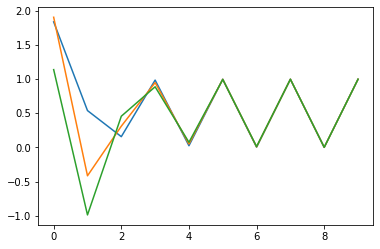

In [8]:
import numpy as np
import matplotlib.pyplot as plt

PE = PositionalEncoding(max_len=100, dropout=0., d_model=10)

#PE(torch.rand(4))
#torch.ones(4)
X = PE(torch.Tensor((1,0,0,0,0,0,0,0,0,0))).detach().numpy()
#plt.plot(range(len(X[0])), X[0])
plt.plot(X[1][0])
plt.plot(X[2][0])
plt.plot(X[3][0])


<!--# Load and batch data-->

# データのロードとバッチ化

<!--
The training process uses Wikitext-2 dataset from ``torchtext``. 
The vocab object is built based on the train dataset and is used to numericalize tokens into tensors. 
Starting from sequential data, the ``batchify()`` function arranges the dataset into columns, trimming off any tokens remaining after the data has been divided into batches of size ``batch_size``.
For instance, with the alphabet as the sequence (total length of 26) and a batch size of 4, we would divide the alphabet into 4 sequences of length 6:
-->

訓練には ``torchtext`` の Wikitext-2 データセットを使用します。
vocab オブジェクトは訓練データセットに基づいて構築され，トークンをテンソルへと数値化するために使用されます。
系列データから ``batchify()`` 関数を使ってデータを列 column に配置し ``batch_size`` の大きさのバッチに分割した後に残ったトークンを切り取ります。
例えば アルファベットをシーケンス (全長26) とし バッチサイズを 4 とすると アルファベットを長さ 6 の 4 つのシーケンスに分割することになります。

\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}

<!--These columns are treated as independent by the model, which means that the dependence of ``G`` and ``F`` can not be learned, but allows more efficient batch processing.-->

これらの列はモデルによって独立したものとして扱われ  ``G`` と ``F`` の依存性を学習することはできませんが、より効率的なバッチ処理が可能になります。




In [9]:
import torchtext
from torchtext.data.utils import get_tokenizer
TEXT = torchtext.data.Field(tokenize=get_tokenizer("basic_english"),
                            init_token='<sos>',
                            eos_token='<eos>',
                            lower=True)
train_txt, val_txt, test_txt = torchtext.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(train_txt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def batchify(data, bsz):
    data = TEXT.numericalize([data.examples[0].text])
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


downloading wikitext-2-v1.zip


wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 8.65MB/s]


extracting


/usr/local/lib/python3.6/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


### 入力系列とターゲット系列を生成するための関数
<!--
### Functions to generate input and target sequence
-->

<!--
``get_batch()`` function generates the input and target sequence for the transformer model. 
It subdivides the source data into chunks of length ``bptt``. 
For the language modeling task, the model needs the following words as ``Target``. For example, with a ``bptt`` value of 2, we’d get the following two Variables for ``i`` = 0:
-->

関数 ``get_batch()`` はトランスフォーマモデルの入力系列と目標系列とを生成します。
ソースデータを長さ ``bptt`` のチャンクに細分化します。
言語モデル課題では，モデルは ``Target`` として以下の単語を必要とします。
例えば、 ``bptt`` の値が 2 の場合、 ``i`` = 0 の場合，以下の 2 つの変数が得られます。

<!--
![](https://github.com/pytorch/tutorials/blob/gh-pages/_downloads/_static/img/transformer_input_target.png?raw=1)
-->

<img src="https://pytorch.org/tutorials/_images/transformer_input_target.png">

<!--
It should be noted that the chunks are along dimension 0, consistent with the ``S`` dimension in the Transformer model. 
The batch dimension ``N`` is along dimension 1.
-->

チャンクは寸法 0 に沿っており、トランスフォーマーモデルの ``S`` 寸法と一致していることに注意する必要があります。
バッチ次元 ``N`` は次元 1 に沿っています。




In [10]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

<!--
# Initiate an instance
-->

# インスタンスの初期化

<!--
The model is set up with the hyperparameter below. 
The vocab size is equal to the length of the vocab object.
-->

モデルは以下のハイパーパラメータで設定されています。
語彙サイズはボキャブオブジェクトの長さに等しいです。

In [11]:
ntokens = len(TEXT.vocab.stoi) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

<!--
# Run the model
-->

# モデルの実行

<!--
[CrossEntropyLoss](https://pytorch.org/docs/master/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss) is applied to track the loss and [SGD](https://pytorch.org/docs/master/optim.html?highlight=sgd#torch.optim.SGD) implements stochastic gradient descent method as the optimizer. 
The initial learning rate is set to 5.0. [StepLR](https://pytorch.org/docs/master/optim.html?highlight=steplr#torch.optim.lr_scheduler.StepLR) is applied to adjust the learn rate through epochs. 
During the training, we use [nn.utils.clip_grad_norm](https://pytorch.org/docs/master/nn.html?highlight=nn%20utils%20clip_grad_norm#torch.nn.utils.clip_grad_norm_) function to scale all the gradient together to prevent exploding.
-->

損失を追跡するために [CrossEntropyLoss](https://pytorch.org/docs/master/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss) を適用し [SGD](https://pytorch.org/docs/master/optim.html?highlight=sgd#torch.optim.SGD) は最適化器として確率的勾配降下法を実装しています。
初期学習率は 5.0 に設定されています。
[StepLR](https://pytorch.org/docs/master/optim.html?highlight=steplr#torch.optim.lr_scheduler.StepLR) はエポック単位で学習率を調整するために適用されている。
学習中は [nn.utils.clip_grad_norm](https://pytorch.org/docs/master/nn.html?highlight=nn%20utils%20clip_grad_norm#torch.nn.utils.clip_grad_norm_) 関数を用いて、爆発しないように全ての勾配をまとめてスケーリングしています。



In [12]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time
def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            output = eval_model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

<!--
Loop over epochs. Save the model if the validation loss is the best we've seen so far. 
Adjust the learning rate after each epoch.
-->
エポックをループします。
検証の損失がこれまでのところ最高であればモデルを保存します。
各エポックの後に学習率を調整します。



In [13]:
best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |   200/ 2981 batches | lr 5.00 | ms/batch 18.39 | loss  7.98 | ppl  2930.49
| epoch   1 |   400/ 2981 batches | lr 5.00 | ms/batch 16.38 | loss  6.78 | ppl   882.26
| epoch   1 |   600/ 2981 batches | lr 5.00 | ms/batch 16.43 | loss  6.36 | ppl   577.99
| epoch   1 |   800/ 2981 batches | lr 5.00 | ms/batch 16.50 | loss  6.23 | ppl   506.77
| epoch   1 |  1000/ 2981 batches | lr 5.00 | ms/batch 16.51 | loss  6.12 | ppl   453.77
| epoch   1 |  1200/ 2981 batches | lr 5.00 | ms/batch 16.57 | loss  6.09 | ppl   440.96
| epoch   1 |  1400/ 2981 batches | lr 5.00 | ms/batch 16.56 | loss  6.04 | ppl   418.54
| epoch   1 |  1600/ 2981 batches | lr 5.00 | ms/batch 16.69 | loss  6.04 | ppl   420.40
| epoch   1 |  1800/ 2981 batches | lr 5.00 | ms/batch 16.68 | loss  5.95 | ppl   385.45
| epoch   1 |  2000/ 2981 batches | lr 5.00 | ms/batch 16.71 | loss  5.95 | ppl   385.00
| epoch   1 |  2200/ 2981 batches | lr 5.00 | ms/batch 16.77 | loss  5.84 | ppl   344.93
| epoch   1 |  2400/ 

<!--
# Evaluate the model with the test dataset
-->

# テストデータセットを用いたモデルの評価
モデルをテストデータセットで評価します。

<!--
Apply the best model to check the result with the test dataset.
-->



In [14]:
test_loss = evaluate(best_model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  5.40 | test ppl   221.43
